# <span style="color:#ffe8d6"><b>Olist EDA Notebook</b></span>
<span style="color:#e9c46a"><i>
#### This notebook is currently under development. I am building functions and visualizations to explore sales trends by category, location, and customer behavior.
</i></span>

In [124]:
import pandas as pd
import altair as alt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from app.utils import preprocessing


# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Suppress warnings
warnings.filterwarnings('ignore')

In [125]:
# Load processed data using the data loading function
data = preprocessing.load_processed_data()

df_customer = data['customer']
df_order = data['order']
df_geo = data['geo']
df_order_item = data['order_item']
df_product = data['product']
df_order_payment = data['order_payment']
df_order_review = data['order_review']
df_seller = data['seller']
df_product_category = data['product_category']


## KPI's

In [126]:
def raise_for_invalid_year(year: int | list[int]) -> bool:

    valid_years = [2016, 2017, 2018, 2019]
    if isinstance(year, int) and year not in valid_years:
        print(f"Year {year} not in {valid_years}")
        return False
    if isinstance(year, list):
        if not all(y in valid_years for y in year):
            print(f"All years must be in {valid_years}")
            return False
    return True


In [127]:
# Total sales

def get_total_revenue(df_order_item: pd.DataFrame, year: int | list[int] = None) -> str:
    raise_for_invalid_year(year)
    merged = df_order_item.merge(df_order[['order_id','purchase_year']], on='order_id', how='inner')
    if year is None:
        return f"${merged['price'].sum().astype(int):,.0f}"
    else:
        df_year = merged[merged['purchase_year'].isin([year])]
        return f"${df_year['price'].sum().astype(int):,.0f}"

get_total_revenue(df_order_item, 2017)


'$6,049,239'

In [128]:
def get_total_orders(df: pd.DataFrame, year: int | list[int] = None) -> str:
    raise_for_invalid_year(year)
    if year is None:
        return f"{df['order_id'].nunique():,.0f}"
    else:
        df_year = df[df['purchase_year'].isin([year])]
        return f"{df_year['order_id'].nunique():,.0f}"

get_total_orders(df_order, 2017)

'45,101'

In [129]:
# Total customers

def get_total_customers(df: pd.DataFrame, year: int | list[int] = None) -> str:
    raise_for_invalid_year(year)
    if year is None:
        return f"{df['customer_id'].nunique():,.0f}"
    else:
        df_year = df[df['purchase_month'].dt.year.isin([year])]
        return f"{df_year['customer_id'].nunique():,.0f}"

get_total_customers(df_order, 2017)

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# Highest selling city

def get_highest_selling_cities(data: dict[str, pd.DataFrame], year: int | list[int] = None) -> str:
    raise_for_invalid_year(year)
    df_order = data['order']
    df_customer = data['customer']

    order_cols = ['order_id', 'customer_id', 'purchase_year']
    customer_cols = ['customer_id', 'city']

    merged = df_customer[customer_cols].merge(df_order[order_cols], on='customer_id', how='inner')
    if year is None:
        return (merged
                        .groupby('city').agg({'order_id': 'count'})
                        .sort_values(by='order_id', ascending=False))
    

    else:
        df_year = merged[merged['purchase_year'].isin([year])]
        return (df_year.groupby('city').agg({'order_id': 'count'})
                        .sort_values(by='order_id', ascending=False))


highest_selling_cities = get_highest_selling_cities(data, 2017)

highest_selling_cities.idxmax()


order_id    sao paulo
dtype: object

In [ ]:
# Highest selling category

def get_highest_selling_categories(data: dict[str, pd.DataFrame], year: int | list[int] = None) -> pd.DataFrame:
    raise_for_invalid_year(year)
    df_order_item = data['order_item']
    df_order = data['order']
    merged = df_order_item.merge(df_order[['order_id','purchase_year']], on='order_id', how='inner')
    if year is None:
        return (merged
        .groupby('category_name')
        .agg({'order_id': 'count'}).sort_values(by='order_id', ascending=False))
    else:
        df_year = merged[merged['purchase_year'].isin([year])]
        return (df_year.groupby('category_name')
        .agg({'order_id': 'count'}).sort_values(by='order_id', ascending=False))

highest_selling_categories = get_highest_selling_categories(data, 2017)

highest_selling_categories.idxmax()

order_id    bed_bath_table
dtype: object

> **KPI Breakdown (For 2017):**
> - Total Revenue: '$7,440,657'
> - Total Orders: '42,672'
> - Top Selling City: 'sao paulo'
> - Top Selling Category: 'bed_bath_table'

## Sales Analysis

In [ ]:
def get_sales_by_region_category(data: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Merge the customer, orders, geo, order item, to get sales by region
    Args:
        data: dict[str, pd.DataFrame]
            Data:
                - customer: pd.DataFrame
                - order: pd.DataFrame
                - geo: pd.DataFrame
                - order_item: pd.DataFrame
    Returns:
        pd.DataFrame - Columns: category_name, region, sales, order_count
    
    Notes:
        - The merging could be done during preprocessing to avoid redundant merging
    """
    
    df_customer = data['customer']
    df_orders = data['order']
    df_geo = data['geo']
    df_order_item = data['order_item']


    # Get unique zips with city, state, lat, lng, and region
    geo_cols = ['zip_code_prefix','region', 'city', 'state', 'latitude', 'longitude']
    unique_zips = (df_geo[geo_cols]
                    .groupby('zip_code_prefix')
                    .first())

    # Merge order and customer data to get zips
    customer_order = df_orders.merge(df_customer[['customer_id','zip_code_prefix']], on='customer_id', how='inner')

    # Merge zips and geo location with customer order data
    customer_order_geo = unique_zips.merge(customer_order, on='zip_code_prefix', how='inner')
    
    customer_order_geo_product = customer_order_geo.merge(df_order_item, on='order_id', how='inner')

    # Calculate sales by region and product category
    sales_by_region = (customer_order_geo_product
            .groupby(["category_name", "region"])
            .agg({"price": "sum", "order_id": "count"})
            .reset_index()
            .rename(columns={"price": "sales", "order_id": "order_count"})
            )
    
    return sales_by_region

sales_by_region_category = get_sales_by_region_category(data)
sales_by_region_category

,category_name,region,sales,order_count
0,agro_industry_and_commerce,Central-West,3355.28,12
1,agro_industry_and_commerce,North,1787.97,7
2,agro_industry_and_commerce,Northeast,11206.08,23
3,agro_industry_and_commerce,South,9129.44,24
4,agro_industry_and_commerce,Southeast,47051.70,146
...,...,...,...,...
329,watches_gifts,Central-West,83237.58,377
330,watches_gifts,North,37470.73,144
331,watches_gifts,Northeast,163965.66,780
332,watches_gifts,South,141538.90,725


In [ ]:
def calculate_ARPU(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the ARPU for each product category and region
    Args:
        df: pd.DataFrame - Requires sales and order_count columns
    Returns:
        pd.DataFrame - Columns: Product Category, Region, Sales, Orders, ARPU
    """


    df_with_ARPU = (df
            .assign(ARPU=lambda x: round(x["sales"] / x["order_count"], 2))
            .sort_values(by="ARPU", ascending=False))
    return df_with_ARPU

sales_by_region_category = calculate_ARPU(sales_by_region_category)
sales_by_region_category

,category_name,region,sales,order_count,ARPU
300,small_appliances_home_oven_and_coffee,North,3998.00,2,1999.00
68,computers,South,21293.85,17,1252.58
65,computers,Central-West,16535.95,14,1181.14
66,computers,North,10995.90,10,1099.59
69,computers,Southeast,114284.72,104,1098.89
...,...,...,...,...,...
119,dvds_blu_ray,North,24.90,1,24.90
120,dvds_blu_ray,Northeast,101.60,5,20.32
259,music,North,16.10,1,16.10
217,home_comfort_2,Northeast,12.90,1,12.90


In [ ]:
# ARPU and total sales by Region and Product Category

def get_sales_by_region_category_bubble_chart(df: pd.DataFrame) -> alt.LayerChart:
    """
    Get the bubble chart for ARPU and total sales by Region and Product Category
    Args:
        df: pd.DataFrame - Requires sales, order_count, and ARPU columns
    Returns:
        alt.Chart
    """

    bubble_chart = alt.Chart(df).mark_circle(opacity=0.7).encode(
        x=alt.X('sales:Q', title='Total Sales (BRL)'),
        y=alt.Y('ARPU:Q', title='Average Revenue per Order (ARPU)'),
        size=alt.Size('order_count:Q', title='Order Count', scale=alt.Scale(range=[30, 1000])),
        color=alt.Color('region:N', title='Region'),
        tooltip=['category_name', 'region', 'sales', 'ARPU', 'order_count']
    ).properties(
        title='Sales vs ARPU by Product Category and Region',
        width=800,
        height=500
    ).interactive()
    rule = alt.Chart(df).mark_rule(color='red', strokeWidth=2).encode(
        y=alt.Y('mean(ARPU):Q', title='Average Revenue per Order (ARPU)')
    )
    rule2 = alt.Chart(df).mark_rule(color='blue', strokeWidth=2).encode(
        x=alt.X('mean(sales):Q', title='Total Sales (BRL)')
    )

    return bubble_chart + rule + rule2

sales_by_region_category_bubble_chart = get_sales_by_region_category_bubble_chart(sales_by_region_category)

sales_by_region_category_bubble_chart


alt.LayerChart(...)

> **Key Insight:** Target increased marketing on products and regions where both ARPU and total sales exceed the average.
> #
> Notable examples:
> - health_beauty (Northeast)
> - watches_gifts (Northeast)
> - cool_stuff (Northeast)
> - auto (Northeast)
> - watches_gifts (Central-West)
> - cool_stuff (South)
> #
> **Recommended Actions:** 
> - Consolidate high-performing product categories to optimize freight cost strategies.
> - Analyze these metrics over time for trends.


## View sales over time

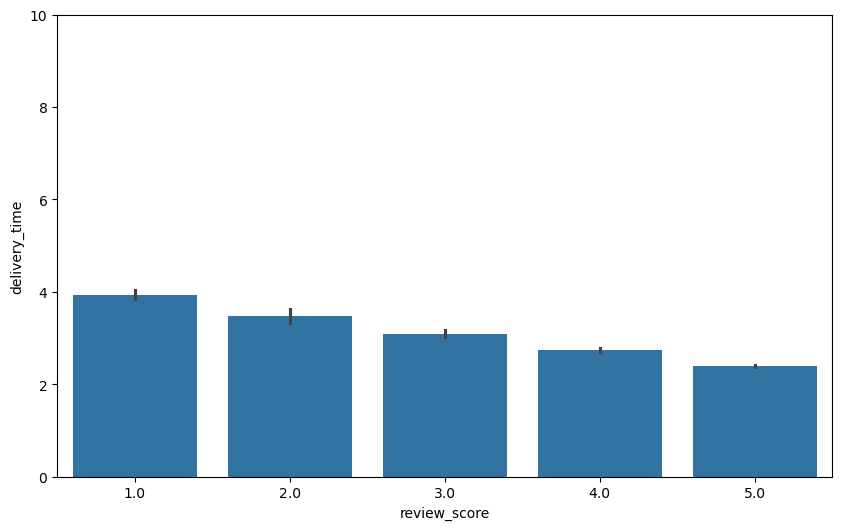

In [ ]:
"""
Delivery Time by Review Score
"""

order_cols = ['order_id', 'delivery_time']
review_cols = ['order_id', 'review_score']

source = df_order[order_cols].merge(df_order_review[review_cols], on='order_id', how='left')


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=source, x='review_score', y='delivery_time', ax=ax)
plt.ylim(0, 10)
plt.show()


